<a href="https://colab.research.google.com/github/HwangSiyeon/ESAA_homework/blob/main/ESAA_HW_0510_RecommendationSystmem_MachineLearningGuide_562_579.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. 추천 시스템

- 추천 시스템 : 하나의 콘텐츠를 선택했을 때 선택된 콘텐츠와 연관된 추천 콘텐츠가 얼마나 사용자의 관심을 끌고 개인에게 맞춘 콘텐츠를 추천

- 에이터가 축적되면 추천이 더욱 정확해지고 다양한 결과를 얻을 수 있는 좋은 선순환 시스템 구축 가증

- 온라인 스토에에서 유용



### 추천 시스템의 유형
- 콘텐츠 기반 필터링
- 협업 필터링 : 최근접 이웃(Nearest Neighbor) & 잠재요인(Latent Factor) 협업 필터링
> 잠재요인(Latent Factor) 협업 필터링: 행렬분해 기법 이용
> 최근에는 개인화 특성을 더 강화하기 위해 하이브리드 형식으로 콘텐츠 기반과 협업 기반을 적절히 결합해 사용

### 콘텐츠 기반 필터링 추천 시스템
- 사용자가 특정 아이템 선호 시 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템 추천

### 최근접 이웃 협업 필터링
- 상품 구매 이력과 같은 사용자 행동 양식만을 기반으로 추천 수행

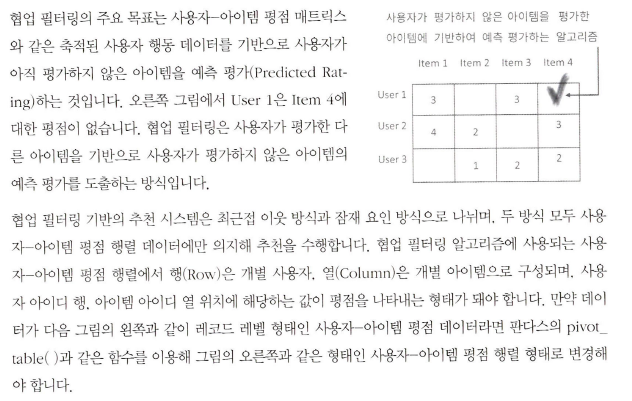

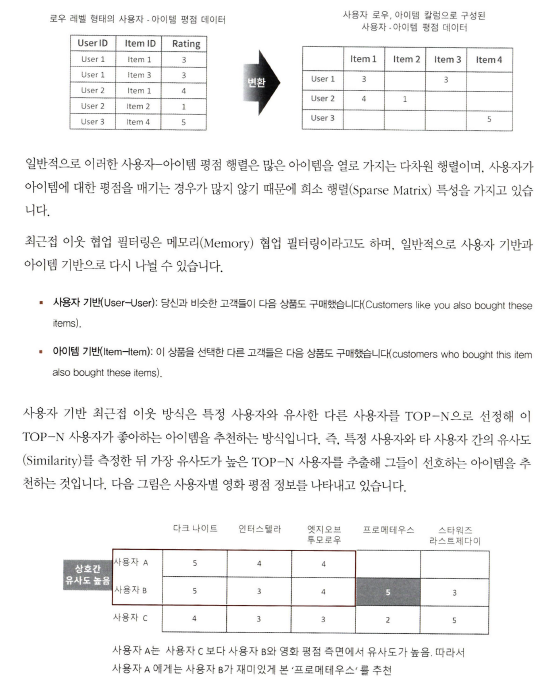

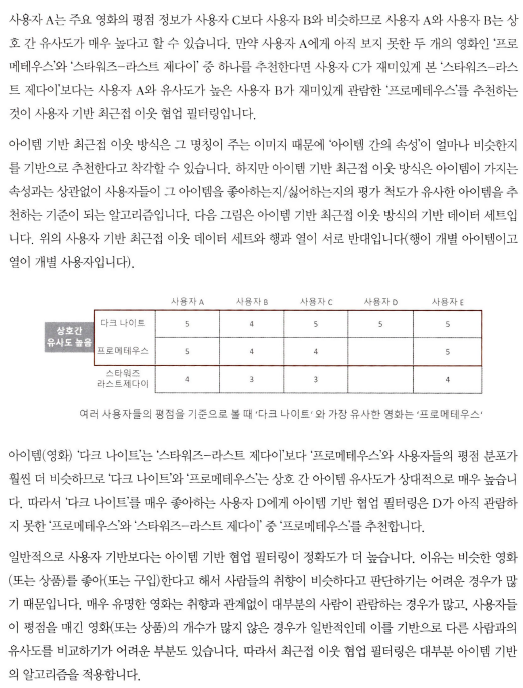

### 잠재요인 협업 필터링
- 사용자-아이템 평점 매트릭스 속에 숨어있는 잠재 요인을 추출해 추천 예측을 할 수 있게 하는 기법
- 행렬분해: 대규모 다차원 행렬을 SVD와 같은 차원감소기버브로 분해하는 과정에서 잠재요인을 추출.

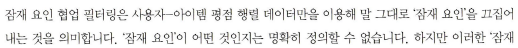
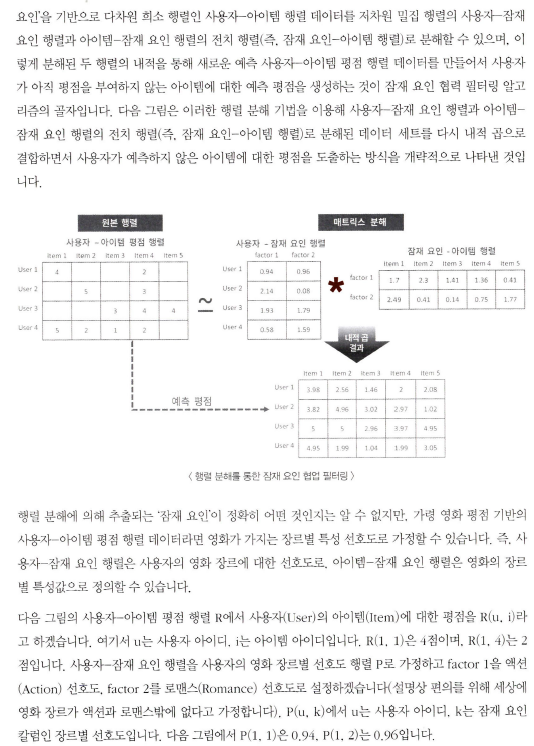
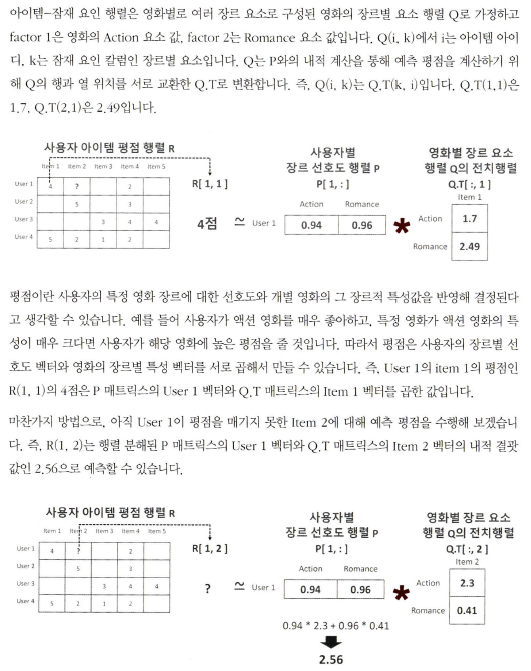

### 행렬 분해의 이해
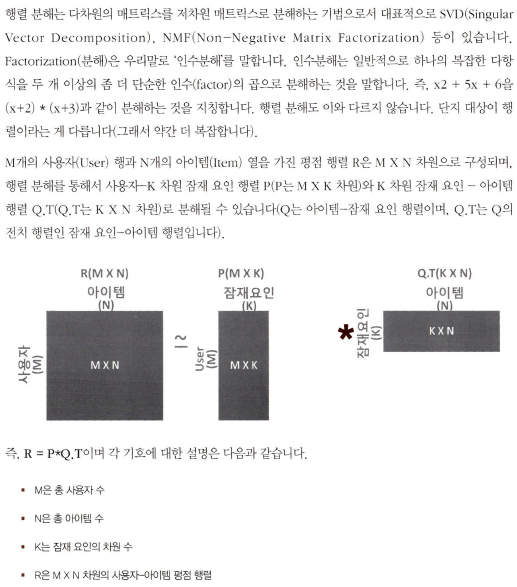
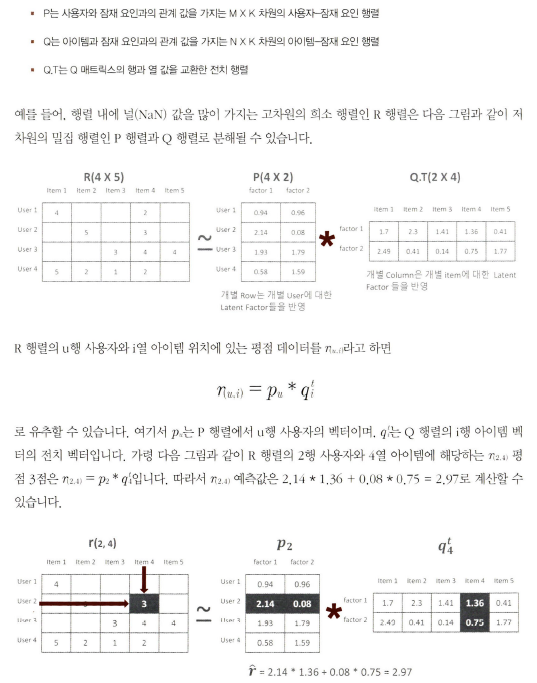

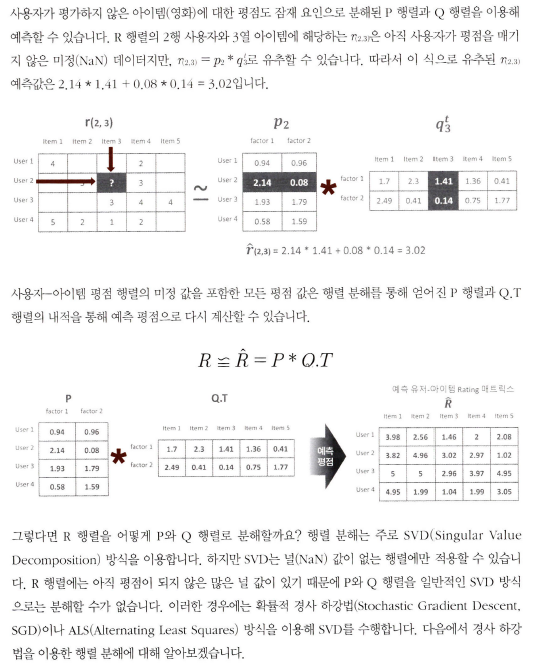

### 확률적 경사하강법을 이용한 행렬 분해
- P와 Q행렬으로 계산된 예측 R행렬 값이 실제 R행렬 값과 가장 최소의 오류를 가질 수 있도록 반복적인 비용함수 최적화를 통해 P와 Q를 유추해내는 것.

1. P와 Q를 임의의 값을 가진 행렬로 설정
2. P와 Q.T값을 곱해 예측 R행렬을 계산하고 예측 R 행렬과 실제R행렬에 해당하는 오류값을 계산
3. 이 오류값을 최소화할 수 있도록 P와 Q행렬을 적절한 값으로 각각 업데이트한다.
4. 만족할 만한 오류값을 가질 때까지 2,3번 작업을 반복하면서 P와 Q값을 업데이트헤 근사화한다.

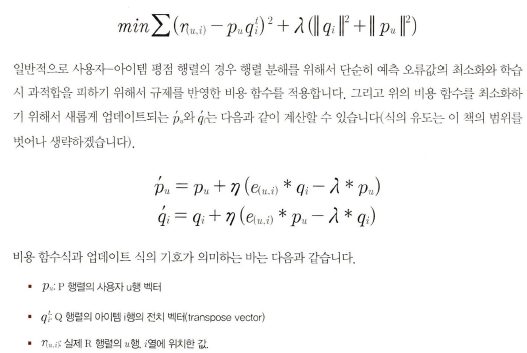

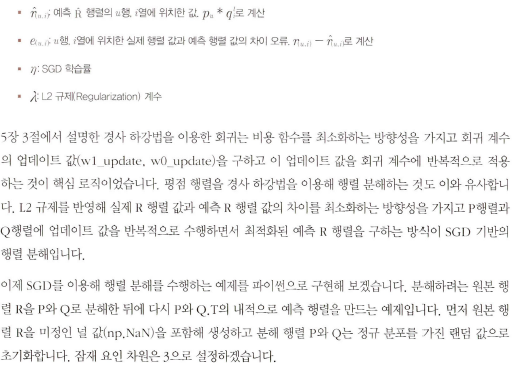

In [ ]:
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재 요인 차원 K는 3으로 설정.
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN],
              [np.NaN, 5, np.NaN, 3, 1],
              [np.NaN, np.NaN, 3, 4, 4],
              [5, 2, 1, 2, np.NaN]])
num_users, num_items = R.shape
K = 3

# P와 Q 행렬의 크기를 지정하고 정규 분포를 가진 임의의 값으로 입력한다.
np.random.seed(1)
P = np.random.normal(scale = 1./K, size = (num_users, K))
Q = np.random.normal(scale = 1./K, size = (num_items, K))

- 다음은 실제R행렬과 예측행렬의 오차를 구하는 함수이다.
- 이 함수는 실제R행렬의 널이 아닌 행렬값의 위치 인덱스를 추출해 이 인덱스에 있는 실제 R행렬값과 분해된 P,Q를 이용해 다시 조합된 예측 행렬 값의 RMSE값을 반환한다.

In [ ]:
from sklearn.metrics import mean_squared_error

def get_rmse(R,P,Q, non_zeros):
  error=0
  # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix = np.dot(P, Q.T)

  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출해  실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind,y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return mse

- 실제 SGD기반으로 행렬분해를 수행한다. 먼저 널값을 제외한 데이터의 행렬 인덱스를 추출한다. step는 SGD를 반복해서 업데이트할 횟수를 의미한다. learning_rate는 SGD의 학습률, r_lambda는 1,2 Regularization 계수이다.

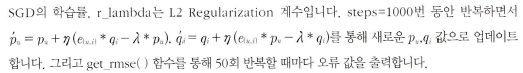

In [ ]:
# R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장.
non_zeros = [(i,j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j]>0]

steps=1000
learning_rate = 0.01
r_lambda = 0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트.
for step in range(steps):
  for i , j , r in non_zeros:
    # 실제 값과 예측 값의 차이인 오류 값 구함
    eij = r - np.dot(P[i, :], Q[j, :].T)
    # Regularization을 반영한 SGD 업데이트 공식 적용
    P[i, :] = P[i, :] + learning_rate*(eij*Q[j, :]-r_lambda*P[i, :])
    Q[j, :] = Q[j, :] + learning_rate*(eij*P[i, :]-r_lambda*Q[j, :])
    rmse = get_rmse(R, P, Q, non_zeros)
    if (step % 50) ==0:
      print("### iteration step: ", step, "rmse: ", rmse)

### iteration step:  0 rmse:  10.624076694463124
### iteration step:  0 rmse:  10.618014679068558
### iteration step:  0 rmse:  10.576218984210831
### iteration step:  0 rmse:  10.564459092175609
### iteration step:  0 rmse:  10.565609906045793
### iteration step:  0 rmse:  10.55739787798783
### iteration step:  0 rmse:  10.545514418598977
### iteration step:  0 rmse:  10.533635410731863
### iteration step:  0 rmse:  10.49863593750931
### iteration step:  0 rmse:  10.486542278270159
### iteration step:  0 rmse:  10.487319115689543
### iteration step:  0 rmse:  10.478470526846758
### iteration step:  50 rmse:  0.25150266645638636
### iteration step:  50 rmse:  0.2513180667075575
### iteration step:  50 rmse:  0.2501971931317088
### iteration step:  50 rmse:  0.25002563176696924
### iteration step:  50 rmse:  0.25012822225833825
### iteration step:  50 rmse:  0.24949312005104154
### iteration step:  50 rmse:  0.24959043831435154
### iteration step:  50 rmse:  0.2491095108622687
### itera

- 이제, 분해된 P와 Q 함수를 P*Q.T로 예측 행렬 만들어서 출력한다

In [ ]:
pred_matrix = np.dot(P,  Q.T)
print('예측행렬 : \n', np.round(pred_matrix, 3))

예측행렬: 
 [[3.99  0.783 1.341 2.003 1.729]
 [6.702 4.978 0.953 2.98  1.003]
 [6.933 0.42  2.987 3.976 3.986]
 [4.968 2.005 1.007 2.018 1.163]]


- 원본 행렬과 비교해 널이 아닌 값은 큰 차이가 나지 않으며 널(Null)인 값은 새로운 예측값으로 채워진다.